In [1]:
%matplotlib inline

import pandas as pd
from plotly import express as px
from plotly import graph_objects as go
from plotly import offline as py
from plotly.subplots import make_subplots
import numpy as np

py.init_notebook_mode()

In [82]:
platforms = ["Pitchfork", "Guardian", "NME", "Spectrum"]
dfs = {platform: 
       pd.read_hdf("C:\\Users\\tommy\\OneDrive\\University\\Year 3\\Third Year Project\\Platform Album Data\\review_data_final.h5", key=platform) for platform in platforms}

In [3]:
# Exploring score missing data

for platform, df in dfs.items():
    
    df.loc[:, "Scores"] = pd.to_numeric(df.loc[:, "Scores"])

for platform in platforms:
    
    print(platform + ": ", dfs[platform].loc[dfs[platform]["Scores"] == -1].shape[0])

Pitchfork:  0
Guardian:  0
NME:  0
Spectrum:  340


All fine except spectrum which seems to be missing a lot of scores. I have cross validated this with the urls and the reviews do not have a listed score on the website so this is no error. We therefore have much less data to work with with regard to spectrum.

In [4]:
# Exploring genre missing data

for platform in ["Guardian", "Pitchfork"]:
    
    print(platform + ": ", dfs[platform].loc[dfs[platform]["Genres"] == "NA"])

Guardian:  Empty DataFrame
Columns: [Platform, Artist, Album, Text, Scores, Genres, Url]
Index: []
Pitchfork:  Empty DataFrame
Columns: [Platform, Artist, Album, Text, Scores, Genres, Url]
Index: []


In [5]:
g_df = dfs["Guardian"]

len(g_df["Genres"].iloc[4])

1

In [6]:
def count_missing(x):
    
    if len(x) == 1:
        return 1
    
    else:
        return 0
    
g_df["Genres"].apply(count_missing).sum()

940

Since all lists are of length 1, we get the first element then repeat

In [7]:
g_df["Genres"] = g_df["Genres"].apply(lambda x: x[0])

g_df["Genres"]

0       
1       
2       
3       
4       
      ..
935     
936     
937     
938     
939     
Name: Genres, Length: 940, dtype: object

In [8]:
len(g_df["Genres"].iloc[4])

0

Now we can count missing

In [9]:
g_df["Genres"].apply(lambda x: len(x) == 0).sum()

940

There are 77 missing genres. This is only just less than 10% of the data so we will just remove these when analysing differences in genre classification.

In [10]:
# Let's take a look at what genres we have

g_df["Genres"].unique()

array([''], dtype=object)

Unfortunately this looks like time for a manual list of relevant genres. Oh dear.

We can at least make life a bit easier by splitting each into a list of genres rather than treating combinations as unique

In [11]:
g_df.loc[:, "Genres"] = g_df.loc[:, "Genres"].apply(lambda x: x.split(", "))

g_df.loc[:, "Genres"]

0      []
1      []
2      []
3      []
4      []
       ..
935    []
936    []
937    []
938    []
939    []
Name: Genres, Length: 940, dtype: object

In [12]:
genres_list = []

for genres in g_df["Genres"]:
    
    for genre in genres:
        
        if genre not in genres_list:
            genres_list.append(genre)
            
genres_list

['']

In [13]:
# Manually reviewed

guardian_genres = ['electronicmusic',
 'popandrock',
 'australian-music',
 'rap',
 'r-and-b',
 'dance-music',
 'indie',
 'experimental-music',
 'americana',
 'country',
 'jazz',
 'punk',
 'hip-hop',
 'psychedelia',
 'disco',
 'metal',
 'soul',
 'folk',
 'clubs',
 'k-pop',
 'grime',
 'motown',
 'dubstep',
 'blues',
 'reggae',
 'classical-music-and-opera',
 'opera',
]

In [14]:
def filter_guardian(x):
    
    remove = []
    
    for genre in x:
        
        if genre not in guardian_genres:
            remove.append(genre)
            
    for genre in remove:
        x.remove(genre)
        
    if not x:
        x = ["NA"]
            
    return x

g_df.loc[:, "Genres"] = g_df.loc[:, "Genres"].apply(filter_guardian)
g_df = g_df.explode("Genres")

g_df.loc[:, "Genres"].unique()

array(['NA'], dtype=object)

In [15]:
g_df.loc[g_df["Genres"] == "NA"].shape[0]

940

In [16]:
g_df.loc[:, "Genres"].value_counts()

NA    940
Name: Genres, dtype: int64

In [17]:
def group_small(x):
    
    if x in ["clubs", "dubstep", "blues", "disco", "k-pop", "reggae", "australian-music", "grime", "motown", "classical-music-and-opera", "opera"]:
        
        x = "Other"
        
    return x

g_df.loc[:, "Genres"] = g_df.loc[:, "Genres"].apply(group_small)

In [18]:
g_genres = g_df.loc[:, "Genres"].unique()

g_genres

array(['NA'], dtype=object)

In [19]:
g_df.loc[g_df["Genres"] == "Other"]

Empty DataFrame
Columns: [Platform, Artist, Album, Text, Scores, Genres, Url]
Index: []

In [20]:
def remove_na(x):
    
    if len(x) > 1 and "NA" in x:
        x.remove("NA")
        
    return x

g_df_genre = g_df.loc[:, ["Artist", "Album", "Scores", "Genres"]]

g_df_genre = g_df_genre.groupby(by=["Artist", "Album"])["Genres"].aggregate(lambda x: ", ".join(tuple(x)))
g_df_genre = g_df_genre.reset_index()

g_df_genre.loc[:, "Genres"] = g_df_genre.loc[:, "Genres"].apply(lambda x: pd.Series(x.split(", ")).unique())
g_df = pd.merge(g_df.loc[:, g_df.columns != "Genres"], g_df_genre.loc[:, ["Artist", "Album", "Genres"]],
                how="left", on=["Artist", "Album"])

g_df["Genres"] = g_df["Genres"].apply(lambda x: " ".join(x))
g_df = g_df.drop_duplicates()

g_df = g_df.reset_index(drop=True)
g_df.loc[:, "Genres"] = g_df.loc[:, "Genres"].apply(lambda x: x.split(" "))
g_df.loc[:, "Genres"] = g_df.loc[:, "Genres"].apply(remove_na)

g_df = g_df.explode("Genres").reset_index(drop=True)
g_df.head(5)

Platform           Artist                 Album  \
0  Guardian        brian eno  foreverandevernomore   
1  Guardian          shygirl                 nymph   
2  Guardian            bjork               fossora   
3  Guardian  yeah yeah yeahs          cool it down   
4  Guardian           alex g  god save the animals   

                                                Text  Scores  \
0  The producer contemplates the future of the pl...       4   
1  British rapper, DJ and singer-songwriter Blane...       4   
2  The pop auteur’s 10th album deals with the dea...       4   
3  Karen O is more incisive than ever on the band...       4   
4  The American musician continues to mine a rich...       4   

                                                 Url Genres  
0  https://www.theguardian.com/music/2022/oct/16/...     NA  
1  https://www.theguardian.com/music/2022/oct/02/...     NA  
2  https://www.theguardian.com/music/2022/oct/01/...     NA  
3  https://www.theguardian.com/music/2022/sep/30/...     NA  
4  https://www.theguardian.com/music/2022/sep/25/...     NA

In [21]:
g_df.loc[g_df["Genres"] == "Other"].iloc[:5, :]

Empty DataFrame
Columns: [Platform, Artist, Album, Text, Scores, Url, Genres]
Index: []

In [81]:
g_df.loc[:, "Genres"].value_counts()

NA    939
Name: Genres, dtype: int64

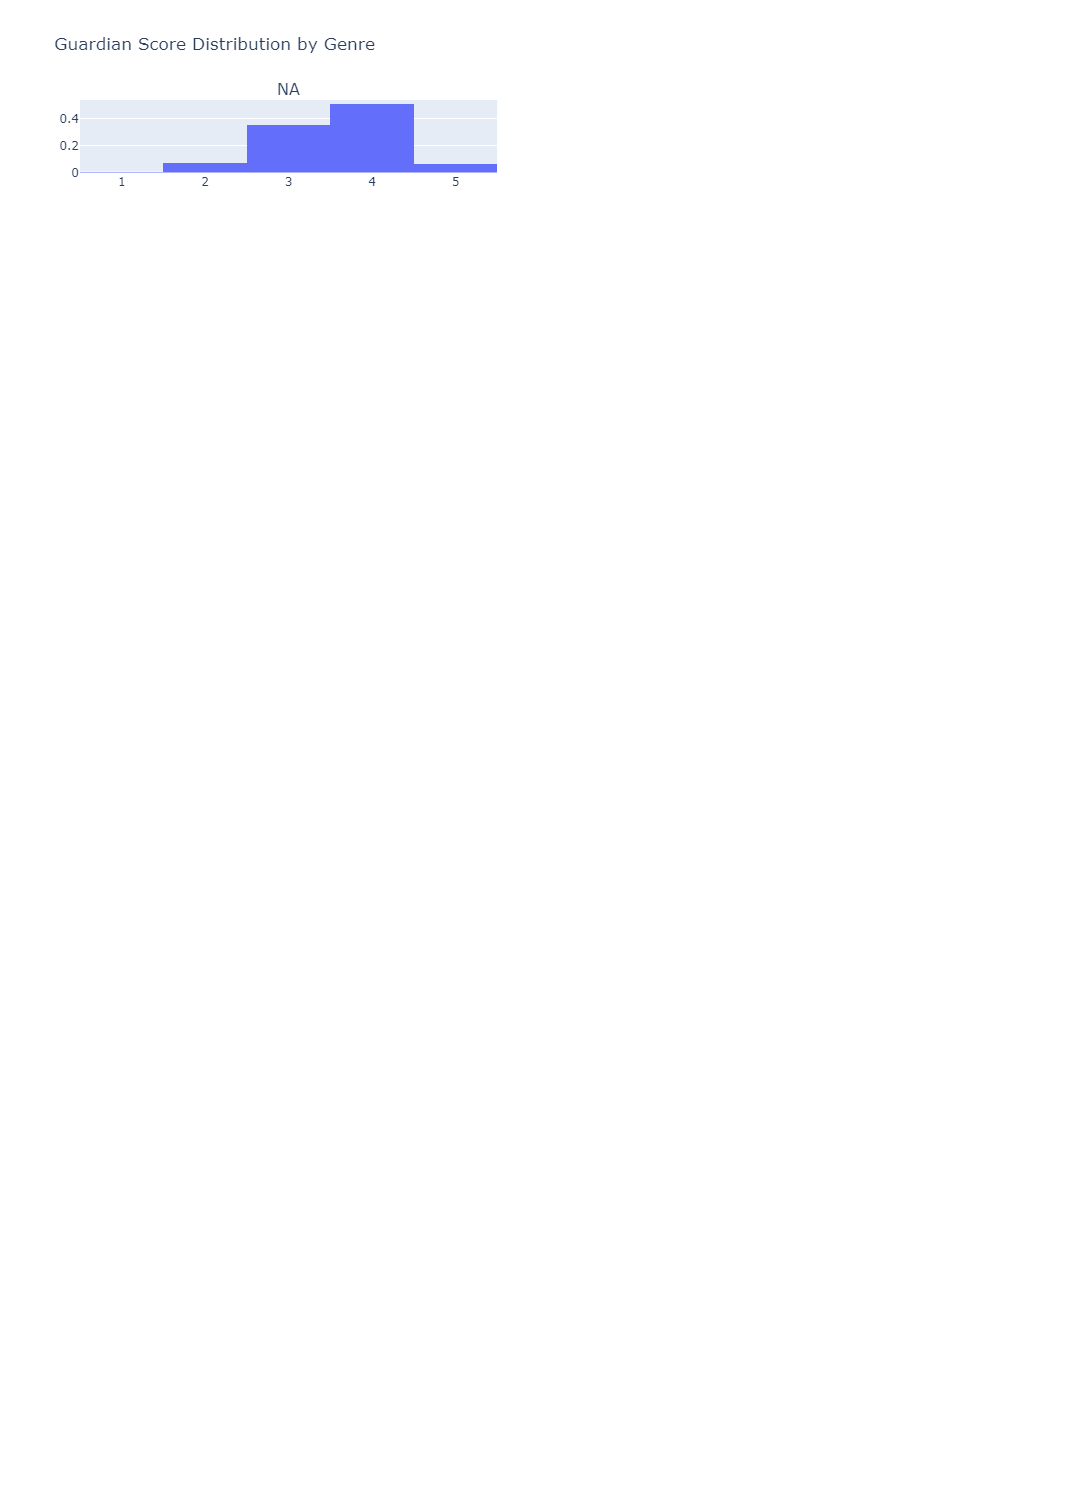

In [78]:
fig = make_subplots(rows=10, cols=2, subplot_titles=g_genres)

for i in range(1, 11):
    for j in range(1, 3):
        
        index = 2 * (i - 1) + j - 1
        
        if index >= len(g_genres):
            break
        
        genre = g_genres[index]
        
        fig.add_trace(go.Histogram(x=g_df.loc[g_df["Genres"] == genre, "Scores"],
                                   xbins={"start": 0.5,
                                          "end": 5.5,
                                          "size": 1},
                                  histnorm="probability density"), row=i, col=j)
                            
fig.update_layout(title_text="Guardian Score Distribution by Genre", height=1500)
fig.update_xaxes(range=[0.5, 5.5])

In [23]:
# Pitchfork genre

pf_df = dfs["Pitchfork"]

def find_second_last(string, char):
    
    count = 0
    i = len(string)
    
    for c in string[::-1]:
        i -= 1
        
        if c == char:
            count += 1
            
            if count == 2:
                return i
            
    return -1

pf_df["Genres"].apply(lambda x: find_second_last(x, ",")).max()
                

64

All genres have had a date added so remove based on the second last comma

In [24]:
def remove_second_last(string, char):
    
    index = find_second_last(string, char)
    
    return string[:index]

pf_df["Genres"] = pf_df["Genres"].apply(lambda x: remove_second_last(x, ","))
    
pf_df["Genres"]

0                           Electronic, Verve / UMC
1                         Electronic, Because Music
2      Electronic / Pop/R&B, One Little Independent
3                           Rock, Secretly Canadian
4                                      Rock, Domino
                           ...                     
935                  Rock, Vagrant / Island Def Jam
936                      Rap, Def Jam / Roc-A-Fella
937                                    Rock, Domino
938                                    Rock, Domino
939                                Rap, Roc-A-Fella
Name: Genres, Length: 940, dtype: object

In [25]:
pf_df["Genres"].unique()[:5]

array(['Electronic, Verve / UMC', 'Electronic, Because Music',
       'Electronic / Pop/R&B, One Little Independent',
       'Rock, Secretly Canadian', 'Rock, Domino'], dtype=object)

In [26]:
# Since pitchfork also collected label data we will remove that also

pf_df["Genres"] = pf_df["Genres"].apply(lambda x: x[:x.find(",")])

In [27]:
pf_df["Genres"].unique()

array(['Electronic', 'Electronic / Pop/R&B', 'Rock', 'Pop/R&B', 'Rap',
       'Pop/R&B / Electronic', 'Pop/R&B / Rap', 'Experimental / Rock',
       'Folk/Country', 'Experimental', 'Electronic / Jazz', 'Metal',
       'Pop/R&B / Rock', 'Electronic / Rock', 'Rock / Rap',
       'Rock / Metal', 'Global', 'Global / Pop/R&B',
       'Rock / Experimental', '4A', 'Spinefar', 'Domin', 'Metal / Rock',
       'AT', 'Jazz / Pop/R&B',
       'RCA / Vice / Mad Decent / Berhane Sound Syste',
       'Electronic / Experimental', 'Captured Track', 'Fir',
       'Jazz / Rock', 'Experimental / Rap', "Honest Jon'"], dtype=object)

Doesn't that look lovely. Except it doesn't because there are still a fair few labels in there that have no genre.

In [28]:
pf_df.loc[pf_df["Genres"].isin(["4A", "Global", "Spinefar", "Domin", "AT", "RCA / Vice / Mad Decent / Berhane Sound Syste", "Captured Track", "Fir",
                              "Honest Jon'"])]

Platform                     Artist                      Album  \
399  Pitchfork             omar souleyman               bahdeni nami   
505  Pitchfork   scott walker + sunn o)))                     soused   
506  Pitchfork   scott walker + sunn o)))                     soused   
518  Pitchfork            electric wizard                time to die   
576  Pitchfork     the amazing snakeheads        amphetamine ballads   
634  Pitchfork             omar souleyman                  wenu wenu   
685  Pitchfork                   hebronix                     unreal   
721  Pitchfork                 snoop lion               reincarnated   
722  Pitchfork                 snoop lion               reincarnated   
749  Pitchfork               caitlin rose                the standin   
831  Pitchfork                  holograms                  holograms   
845  Pitchfork           mission of burma                    unsound   
881  Pitchfork  rocket juice and the moon  rocket juice and the moon   
882  Pitchfork  rocket juice and the moon  rocket juice and the moon   

                                                  Text  Scores  \
399  Syrian singer Omar Souleyman's first proper st...     6.2   
505  The pairing of Scott Walker and Sunn O)))  is ...     7.4   
506  The pairing of Scott Walker and Sunn O)))  is ...     7.4   
518  The latest effort from England’s reigning doom...     7.9   
576  Short bursts of anger snap into place in the d...     6.4   
634  Syrian singer Omar Souleyman’s Wenu Wenu is te...     7.2   
685  The ex-Yuck frontman Daniel Blumberg's first a...     6.7   
721  Snoop Dogg's dalliance with reggae was documen...     5.0   
722  Snoop Dogg's dalliance with reggae was documen...     5.0   
749  The Nashville singer-songwriter Caitlin Rose s...     7.0   
831  On their self-titled debut, the Stockholm band...     7.1   
845  A decade into their second career, Mission of ...     7.7   
881  Damon Albarn, former Fela Kuti drummer Tony Al...     6.1   
882  Damon Albarn, former Fela Kuti drummer Tony Al...     6.1   

                                            Genres  \
399                                         Global   
505                                             4A   
506                                             4A   
518                                       Spinefar   
576                                          Domin   
634                                         Global   
685                                             AT   
721  RCA / Vice / Mad Decent / Berhane Sound Syste   
722  RCA / Vice / Mad Decent / Berhane Sound Syste   
749                                             AT   
831                                 Captured Track   
845                                            Fir   
881                                    Honest Jon'   
882                                    Honest Jon'   

                                                   Url  
399  https://www.pitchfork.com/reviews/albums/20830...  
505  https://www.pitchfork.com/reviews/albums/19946...  
506  https://www.pitchfork.com/reviews/albums/19946...  
518  https://www.pitchfork.com/reviews/albums/19622...  
576  https://www.pitchfork.com/reviews/albums/19640...  
634  https://www.pitchfork.com/reviews/albums/18665...  
685  https://www.pitchfork.com/reviews/albums/18292...  
721  https://www.pitchfork.com/reviews/albums/17920...  
722  https://www.pitchfork.com/reviews/albums/17920...  
749  https://www.pitchfork.com/reviews/albums/17796...  
831  https://www.pitchfork.com/reviews/albums/16901...  
845  https://www.pitchfork.com/reviews/albums/16815...  
881  https://www.pitchfork.com/reviews/albums/16365...  
882  https://www.pitchfork.com/reviews/albums/16365...

Upon spot checking the only legitimate genre of the above list is global so we will set the rest to NA as they have no genre.

In [29]:
pf_df.loc[pf_df["Genres"].isin(["4A", "Spinefar", "Domin", "AT", "Captured Track", "Fir",
                              "Honest Jon'", "RCA / Vice / Mad Decent / Berhane Sound Syste"]), "Genres"] = "NA"

pf_df.loc[pf_df["Genres"] == "NA"]

Platform                     Artist                      Album  \
505  Pitchfork   scott walker + sunn o)))                     soused   
506  Pitchfork   scott walker + sunn o)))                     soused   
518  Pitchfork            electric wizard                time to die   
576  Pitchfork     the amazing snakeheads        amphetamine ballads   
685  Pitchfork                   hebronix                     unreal   
721  Pitchfork                 snoop lion               reincarnated   
722  Pitchfork                 snoop lion               reincarnated   
749  Pitchfork               caitlin rose                the standin   
831  Pitchfork                  holograms                  holograms   
845  Pitchfork           mission of burma                    unsound   
881  Pitchfork  rocket juice and the moon  rocket juice and the moon   
882  Pitchfork  rocket juice and the moon  rocket juice and the moon   

                                                  Text  Scores Genres  \
505  The pairing of Scott Walker and Sunn O)))  is ...     7.4     NA   
506  The pairing of Scott Walker and Sunn O)))  is ...     7.4     NA   
518  The latest effort from England’s reigning doom...     7.9     NA   
576  Short bursts of anger snap into place in the d...     6.4     NA   
685  The ex-Yuck frontman Daniel Blumberg's first a...     6.7     NA   
721  Snoop Dogg's dalliance with reggae was documen...     5.0     NA   
722  Snoop Dogg's dalliance with reggae was documen...     5.0     NA   
749  The Nashville singer-songwriter Caitlin Rose s...     7.0     NA   
831  On their self-titled debut, the Stockholm band...     7.1     NA   
845  A decade into their second career, Mission of ...     7.7     NA   
881  Damon Albarn, former Fela Kuti drummer Tony Al...     6.1     NA   
882  Damon Albarn, former Fela Kuti drummer Tony Al...     6.1     NA   

                                                   Url  
505  https://www.pitchfork.com/reviews/albums/19946...  
506  https://www.pitchfork.com/reviews/albums/19946...  
518  https://www.pitchfork.com/reviews/albums/19622...  
576  https://www.pitchfork.com/reviews/albums/19640...  
685  https://www.pitchfork.com/reviews/albums/18292...  
721  https://www.pitchfork.com/reviews/albums/17920...  
722  https://www.pitchfork.com/reviews/albums/17920...  
749  https://www.pitchfork.com/reviews/albums/17796...  
831  https://www.pitchfork.com/reviews/albums/16901...  
845  https://www.pitchfork.com/reviews/albums/16815...  
881  https://www.pitchfork.com/reviews/albums/16365...  
882  https://www.pitchfork.com/reviews/albums/16365...

In [30]:
pf_df.loc[:, "Genres"].unique()

array(['Electronic', 'Electronic / Pop/R&B', 'Rock', 'Pop/R&B', 'Rap',
       'Pop/R&B / Electronic', 'Pop/R&B / Rap', 'Experimental / Rock',
       'Folk/Country', 'Experimental', 'Electronic / Jazz', 'Metal',
       'Pop/R&B / Rock', 'Electronic / Rock', 'Rock / Rap',
       'Rock / Metal', 'Global', 'Global / Pop/R&B',
       'Rock / Experimental', 'NA', 'Metal / Rock', 'Jazz / Pop/R&B',
       'Electronic / Experimental', 'Jazz / Rock', 'Experimental / Rap'],
      dtype=object)

Much better.

In [31]:
def pitchfork_split(x):
    
    x = x.split(" / ")
    
    return [e.strip() for e in x]

pf_df.loc[:, "Genres"] = pf_df.loc[:, "Genres"].apply(pitchfork_split)


In [32]:
pf_df = pf_df.explode("Genres")

In [33]:
pf_df

Platform           Artist                              Album  \
0    Pitchfork        brian eno               foreverandevernomore   
1    Pitchfork          shygirl                              nymph   
2    Pitchfork            bjork                            fossora   
2    Pitchfork            bjork                            fossora   
3    Pitchfork  yeah yeah yeahs                       cool it down   
..         ...              ...                                ...   
935  Pitchfork        pj harvey                  let england shake   
936  Pitchfork       kanye west  my beautiful dark twisted fantasy   
937  Pitchfork   arctic monkeys                             humbug   
938  Pitchfork   arctic monkeys                             humbug   
939  Pitchfork       kanye west                808s and heartbreak   

                                                  Text  Scores      Genres  \
0    Confronting the climate crisis and the prospec...     7.5  Electronic   
1    Sensuous, funny, and smartly produced, the Lon...     8.0  Electronic   
2    With her 10th album, Björk is grounded back on...     8.4  Electronic   
2    With her 10th album, Björk is grounded back on...     8.4     Pop/R&B   
3    The trio’s first album in nine years ushers in...     7.4        Rock   
..                                                 ...     ...         ...   
935  The always-unpredictable singer-songwriter ret...     8.8        Rock   
936  Kanye's big year culminates in an LP that feel...    10.0         Rap   
937  The Arctics expand their sound with the help o...     7.2        Rock   
938  The Arctics expand their sound with the help o...     7.2        Rock   
939   Poor Kanye West. The guy was already a ball o...     7.6         Rap   

                                                   Url  
0    https://www.pitchfork.com/reviews/albums/brian...  
1    https://www.pitchfork.com/reviews/albums/shygi...  
2    https://www.pitchfork.com/reviews/albums/bjork...  
2    https://www.pitchfork.com/reviews/albums/bjork...  
3    https://www.pitchfork.com/reviews/albums/yeah-...  
..                                                 ...  
935  https://www.pitchfork.com/reviews/albums/15120...  
936  https://www.pitchfork.com/reviews/albums/14880...  
937  https://www.pitchfork.com/reviews/albums/13374...  
938  https://www.pitchfork.com/reviews/albums/13374...  
939  https://www.pitchfork.com/reviews/albums/12498...  

[1033 rows x 7 columns]

In [34]:
pf_genres = pf_df.loc[:, "Genres"].unique()
len(pf_genres)

10

In [35]:
pf_summ_genre = pf_df.groupby("Genres").agg({"Scores": ["mean", "std"]})
pf_summ_genre["Count"] = pf_df.groupby("Genres").size()
pf_summ_genre["% of Albums"] = pf_summ_genre["Count"] * 100 / 940
round(pf_summ_genre, 2)

Scores       Count % of Albums
               mean   std                  
Genres                                     
Electronic     7.27  1.12   134       14.26
Experimental   7.69  0.92    42        4.47
Folk/Country   7.61  1.00    28        2.98
Global         7.02  0.53     8        0.85
Jazz           6.60  1.44     3        0.32
Metal          7.07  0.88    10        1.06
NA             6.65  0.96    12        1.28
Pop/R&B        7.32  1.05   206       21.91
Rap            7.45  1.25    71        7.55
Rock           7.26  1.13   519       55.21

In [36]:
g_summ_genre = g_df.copy()
g_summ_genre.loc[:, "Scores"] = g_summ_genre.loc[:, "Scores"] * 2
g_summ_genre = g_summ_genre.groupby("Genres").agg({"Scores": ["mean", "std"]})
g_summ_genre["Count"] = g_df.groupby("Genres").size()
g_summ_genre["% of Albums"] = g_summ_genre["Count"] * 100 / 940
round(g_summ_genre, 2)

Scores       Count % of Albums
         mean   std                  
Genres                               
NA       7.13  1.47   939       99.89

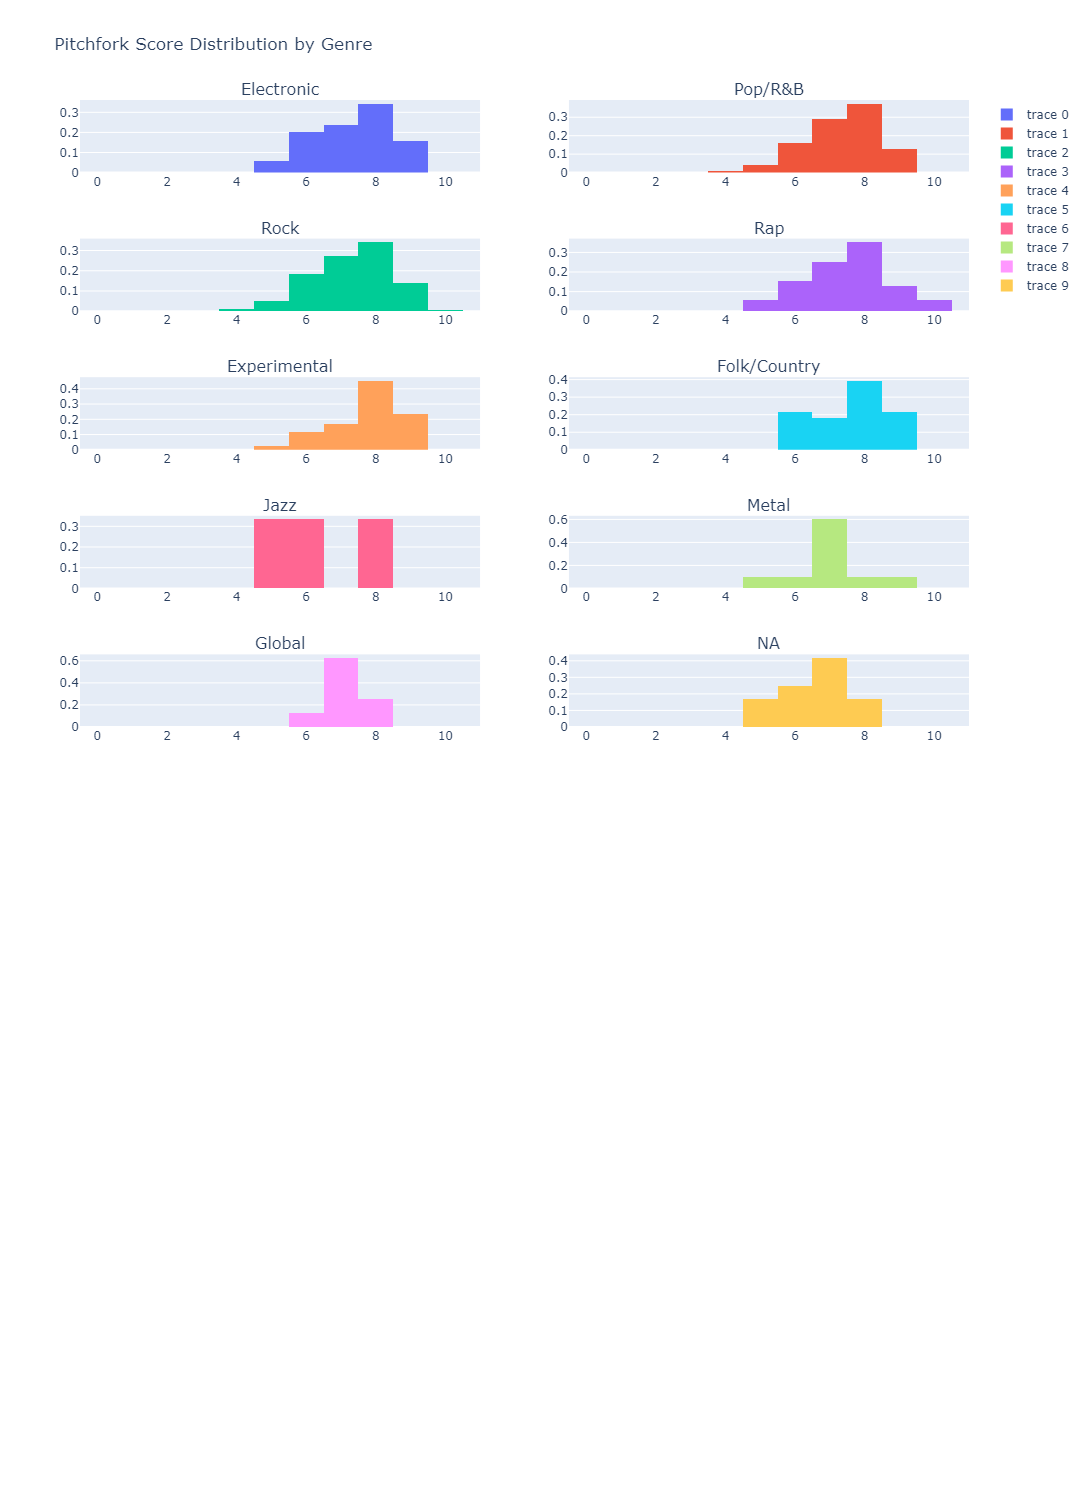

In [37]:
fig = make_subplots(rows=10, cols=2, subplot_titles=pf_genres)

for i in range(1, 7):
    for j in range(1, 3):
        
        index = 2 * (i - 1) + j - 1              
    
        if index >= len(pf_genres):
            break
    
        genre = pf_genres[index]
        
        fig.add_trace(go.Histogram(x=pf_df.loc[pf_df["Genres"] == genre, "Scores"],
                                   xbins={"start": -0.5,
                                          "end": 10.5,
                                          "size": 1},
                                  histnorm="probability density"), row=i, col=j)
        
fig.update_layout(title_text="Pitchfork Score Distribution by Genre", height=1500)
fig.update_xaxes(range=[-0.5, 11])
        
fig

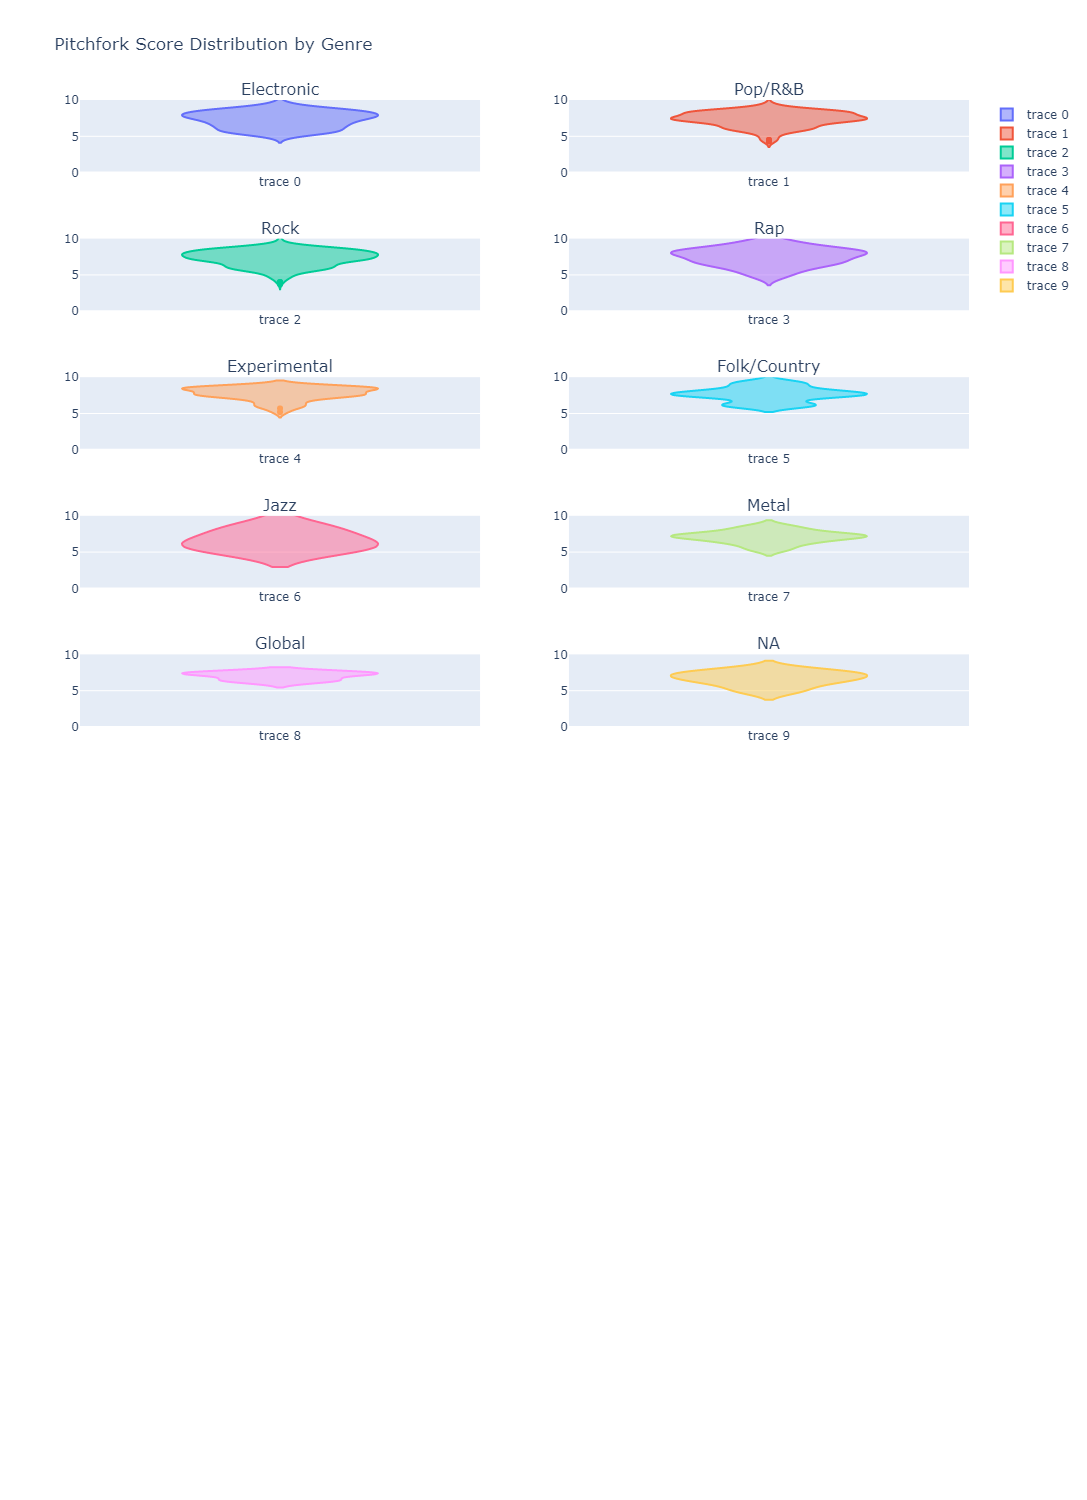

In [38]:
fig = make_subplots(rows=10, cols=2, subplot_titles=pf_genres)

for i in range(1, 7):
    for j in range(1, 3):
        
        index = 2 * (i - 1) + j - 1
    
        if index >= len(pf_genres):
            break
        
        genre = pf_genres[index]
        
        fig.add_trace(go.Violin(y=pf_df.loc[pf_df["Genres"] == genre, "Scores"]), row=i, col=j)
        
fig.update_layout(title_text="Pitchfork Score Distribution by Genre", height=1500)
fig.update_yaxes(range=[0, 10])
        
fig

In [39]:
genre_df = pd.merge(g_df.loc[:, ["Artist", "Album", "Genres"]].rename({"Genres": "Guardian Genres"}, axis=1),
                    pf_df.loc[:, ["Artist", "Album", "Genres"]].rename({"Genres": "Pitchfork Genres"}, axis=1),
                    how="inner", on=["Artist", "Album"]).drop_duplicates().reset_index(drop=True)

genre_cross = pd.crosstab(genre_df.loc[:, "Guardian Genres"], genre_df.loc[:, "Pitchfork Genres"], normalize="index")

(genre_cross * 100).style.background_gradient()

In [40]:
g_split = g_df.copy()
g_split.loc[g_split["Genres"] == "popandrock", "Genres"] = g_split.loc[
    g_split["Genres"] == "popandrock", "Genres"].apply(lambda x: ["Pop", "Rock"])
g_split = g_split.explode("Genres")

pf_split = pf_df.copy()
pf_split.loc[pf_split["Genres"] == "Pop/R&B", "Genres"] = pf_split.loc[
    pf_split["Genres"] == "Pop/R&B", "Genres"].apply(lambda x: ["Pop", "R&B"])
pf_split = pf_split.explode("Genres")

genre_df = pd.merge(g_split.loc[:, ["Artist", "Album", "Genres"]].rename({"Genres": "Guardian Genres"}, axis=1),
                    pf_split.loc[:, ["Artist", "Album", "Genres"]].rename({"Genres": "Pitchfork Genres"}, axis=1),
                    how="inner", on=["Artist", "Album"]).drop_duplicates().reset_index(drop=True)

genre_cross = pd.crosstab(genre_df.loc[:, "Guardian Genres"], genre_df.loc[:, "Pitchfork Genres"], normalize="index")
genre_cross

Pitchfork Genres  Electronic  Experimental  Folk/Country    Global      Jazz  \
Guardian Genres                                                                
NA                  0.106843      0.034814       0.02401  0.006002  0.003601   

Pitchfork Genres     Metal        NA       Pop       R&B       Rap     Rock  
Guardian Genres                                                              
NA                0.010804  0.010804  0.158463  0.158463  0.061224  0.42497

Let's try grouping together intuitively

In [41]:
mappings = {"dance-music": "Electronic",
            "electronicmusic": "Electronic",
            "folk": "Folk_Country",
            "country": "Folk_Country",
            "americana": "Folk_Country",
            "hip-hop": "Rap",
            "Other": "NA",
            "indie": "Rock",
            "punk": "Rock",
            "soul": "R&B",
            "psychedelia": "Rock",
            "experimental-music": "Experimental",
            "jazz": "Jazz",
            "metal": "Metal",
            "rap": "Rap",
            "r-and-b": "R&B"}

pf_mappings = {"Folk/Country": "Folk_Country",
               "Global": "NA",}

def map_g_genre(x, mappings):
    
    if x in mappings.keys():
        x = mappings[x]
        
    return x

genre_df.loc[:, "Guardian Genres"] = genre_df.loc[:, "Guardian Genres"].apply(lambda x: map_g_genre(x, mappings))
genre_df.loc[:, "Pitchfork Genres"] = genre_df.loc[:, "Pitchfork Genres"].apply(lambda x: map_g_genre(x, pf_mappings))

mapped_genre_cross = pd.crosstab(genre_df.loc[:, "Guardian Genres"], genre_df.loc[:, "Pitchfork Genres"], normalize="columns")
mapped_genre_cross.style.background_gradient().format("{0:.2%}")

In [42]:
genres = ["Electronic", "Experimental", "Folk_Country", "Jazz", "Metal", "NA", "Pop", "R&B", "Rap", "Rock"]
genre_set = genre_df.groupby(["Album", "Artist"]).agg(lambda x: set(x))

In [43]:
genre_set.loc[genre_set["Guardian Genres"].apply(lambda x: "Jazz" in x), :]

Empty DataFrame
Columns: [Guardian Genres, Pitchfork Genres]
Index: []

In [44]:
crosstab2 = {genre: {genre: 0 for genre in genres} for genre in genres}

for g, pf in zip(list(genre_set.loc[:, "Guardian Genres"]), list(genre_set.loc[:, "Pitchfork Genres"])):
    
    correct = g.intersection(pf)
    incorrect = g.symmetric_difference(pf)
    
    n_correct = len(correct)
    n_incorrect = len(incorrect)
    
    if n_correct >= 1:
        
        for genre in correct:
            crosstab2[genre][genre] += 1 / n_correct
    else:
        
        n_total = len(g) * len(pf)
        
        for i in range(len(g)):
            for j in range(len(pf)):

                crosstab2[list(g)[i]][list(pf)[j]] += 1 / n_total

crosstab2 = {genre: list(crosstab2[genre].values()) for genre in genres}

crosstab2_df = pd.DataFrame(crosstab2, index=genres)
crosstab2_df.div(crosstab2_df.sum(axis=0), axis=1).style.background_gradient().format("{0:.2%}")

C:\Users\tommy\PycharmProjects\Third-Year-Project\venv\lib\site-packages\pandas\io\formats\style.py:3555: RuntimeWarning:

All-NaN slice encountered

C:\Users\tommy\PycharmProjects\Third-Year-Project\venv\lib\site-packages\pandas\io\formats\style.py:3556: RuntimeWarning:

All-NaN slice encountered



In [45]:
d_sum = sum([crosstab2_df.iloc[i, i] for i in range(crosstab2_df.shape[0])])
d_sum / 641 * 100

2.1840873634945397

In [46]:
crosstab3 = {genre: {genre: 0 for genre in genres} for genre in genres}

for g, pf in zip(list(genre_set.loc[:, "Guardian Genres"]), list(genre_set.loc[:, "Pitchfork Genres"])):
    
    correct = g.intersection(pf)
    incorrect = g.symmetric_difference(pf)
    
    n_incorrect = len(incorrect)
    n_correct = len(correct)
    
    if n_incorrect == 0:
        
        for genre in correct:
            
            crosstab3[genre][genre] += 1 / n_correct
    else:
        
        n_total = len(g) * len(pf)
        
        for i in range(len(g)):
            for j in range(len(pf)):

                crosstab3[list(g)[i]][list(pf)[j]] += 1 / n_total

crosstab3 = {genre: list(crosstab3[genre].values()) for genre in genres}

crosstab3_df = pd.DataFrame(crosstab3, index=genres)
crosstab3_df.div(crosstab3_df.sum(axis=0), axis=1).style.background_gradient().format("{0:.2%}")

C:\Users\tommy\PycharmProjects\Third-Year-Project\venv\lib\site-packages\pandas\io\formats\style.py:3555: RuntimeWarning:

All-NaN slice encountered

C:\Users\tommy\PycharmProjects\Third-Year-Project\venv\lib\site-packages\pandas\io\formats\style.py:3556: RuntimeWarning:

All-NaN slice encountered



In [47]:
def calculate_kappa(df):
    
    p_e = sum([df.loc[genre, :].sum() * df.loc[:, genre].sum()]) / (641 ** 2)
    p_0 = sum([df.iloc[i, i] for i in range(df.shape[0])]) / 641
    
    return (p_0 - p_e) / (1 - p_e)

print(f"Method 1 kappa: {calculate_kappa(crosstab2_df)}")
print(f"Method 2 kappa: {calculate_kappa(crosstab3_df)}")

Method 1 kappa: 0.0
Method 2 kappa: 0.0


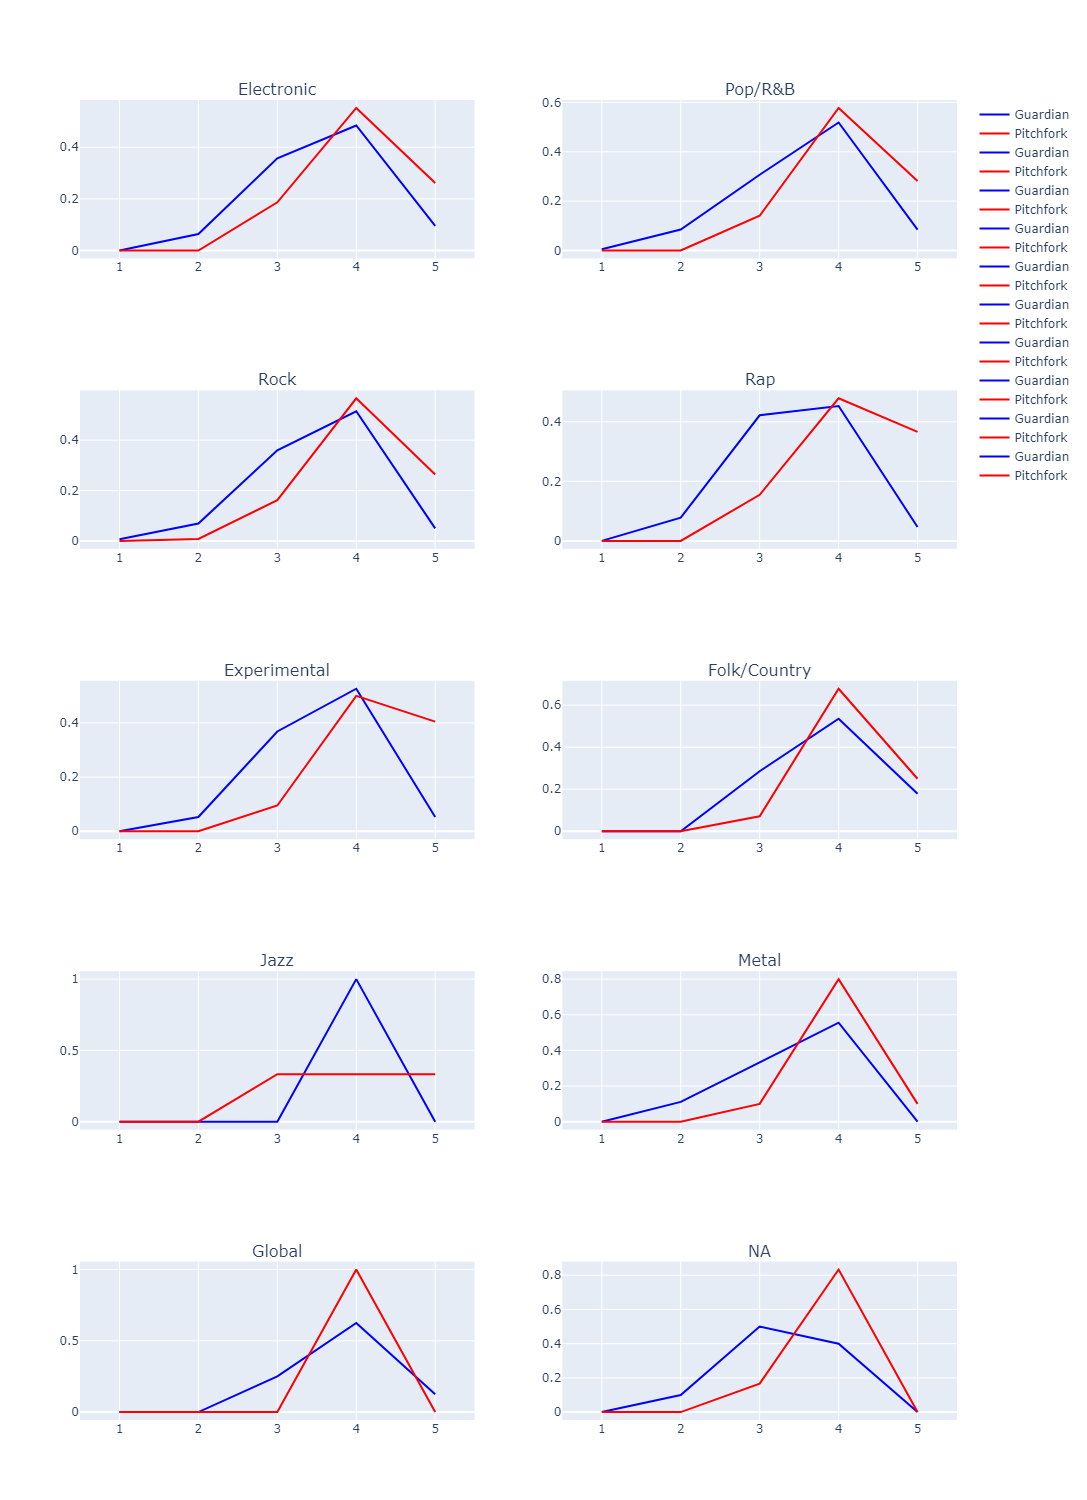

In [48]:
from math import ceil

fig = make_subplots(rows=5, cols=2, subplot_titles=pf_genres)
dist_g = g_df.copy()
dist_pf = pf_df.copy()

dist_g.loc[:, "Genres"] = dist_pf.loc[:, "Genres"].reset_index(drop=True)

dist_df = pd.concat([dist_g.loc[:, ["Artist", "Album", "Genres", "Scores", "Platform"]], 
                   dist_pf.loc[:, ["Artist", "Album", "Genres", "Scores", "Platform"]]]).reset_index(drop=True)

dist_df.loc[dist_df["Platform"] == "Pitchfork", "Scores"] = dist_df.loc[dist_df["Platform"] == "Pitchfork", "Scores"].apply(lambda x: ceil(x / 2))

dist_data = {}

for genre in pf_genres:
    
    g_genre_data = dist_df.loc[(dist_df["Platform"] == "Guardian") & (dist_df["Genres"] == genre), "Scores"].value_counts(
        normalize=True).reindex([x for x in range(1, 6)], fill_value=0)
    pf_genre_data = dist_df.loc[(dist_df["Platform"] == "Pitchfork") & (dist_df["Genres"] == genre), "Scores"].value_counts(
        normalize=True).reindex([x for x in range(1, 6)], fill_value=0)
    
    dist_data[genre] = [pd.DataFrame({"Platform": ["Guardian" for x in range(g_genre_data.shape[0])],
                                                "Scores": g_genre_data.index,
                                                "Proportion": g_genre_data.values}).sort_values("Scores"),
                                  pd.DataFrame({"Platform": ["Pitchfork" for x in range(pf_genre_data.shape[0])],
                                                "Scores": pf_genre_data.index,
                                                "Proportion": pf_genre_data.values}).sort_values("Scores")]

for i in range(1, 6):
    for j in range(1, 3):

        index = 2 * (i - 1) + j - 1
        
        if index >= len(pf_genres):
            break
        
        genre = pf_genres[index]        
        fig.add_trace(go.Scatter(x=dist_data[genre][0].loc[:, "Scores"], y=dist_data[genre][0].loc[:, "Proportion"], mode="lines",
                                line=dict(color="blue"), name="Guardian"), row=i, col=j)
        fig.add_trace(go.Scatter(x=dist_data[genre][1].loc[:, "Scores"], y=dist_data[genre][1].loc[:, "Proportion"], mode="lines",
                                line=dict(color="red"), name="Pitchfork"), row=i, col=j)

fig.update_layout(height=1500)
fig.update_xaxes(range=[0.5, 5.5])

In [49]:
g_df_ave = g_df.groupby(by=["Album", "Artist"])["Scores"].mean().reset_index()
g_df_ave = pd.merge(g_df_ave, g_df_genre.loc[:, ["Artist", "Album", "Genres"]],
                    on=["Artist", "Album"], how="inner")

dfs_ave = {k: df.drop_duplicates(subset=["Artist", "Album"]) for k, df in dfs.items()}
dfs_ave["Guardian"] = g_df_ave

[df.shape[0] for df in dfs_ave.values()]

[641, 641, 641, 641]

In [50]:
g_df_ave

Album        Artist  Scores Genres
0              1989  taylor swift     4.0   [NA]
1                 2   mac demarco     3.0   [NA]
2                25         adele     3.0   [NA]
3              2:54          2:54     2.0   [NA]
4                 4       beyonce     3.5   [NA]
..              ...           ...     ...    ...
636          yeezus    kanye west     4.0   [NA]
637    you're dead!  flying lotus     5.0   [NA]
638  you're nothing        iceage     3.0   [NA]
639  you're the man   marvin gaye     3.0   [NA]
640            yuck          yuck     4.0   [NA]

[641 rows x 4 columns]

In [51]:
pf_df_ave = dfs_ave["Pitchfork"]

genre_df_ave = pd.merge(g_df_ave.explode("Genres").loc[:, ["Artist", "Album", "Genres"]], 
                        pf_df_ave.explode("Genres").loc[:, ["Artist", "Album", "Genres"]],
                    how="inner", on=["Artist", "Album"]).reset_index(drop=True)

genre_cross = pd.crosstab(genre_df.loc[:, "Guardian Genres"], genre_df.loc[:, "Pitchfork Genres"])
genre_cross

Pitchfork Genres  Electronic  Experimental  Folk_Country  Jazz  Metal  NA  \
Guardian Genres                                                             
NA                        89            29            20     3      9  14   

Pitchfork Genres  Pop  R&B  Rap  Rock  
Guardian Genres                        
NA                132  132   51   354

There is no missing data for genre and score so we can move on

## EDA on score data

In [52]:
# First removing the null data for spectrum

score_dfs = {platform: df.copy().sort_values("Scores") for platform, df in dfs_ave.items()}
score_dfs["Spectrum"] = score_dfs["Spectrum"].loc[score_dfs["Spectrum"]["Scores"] != - 1]

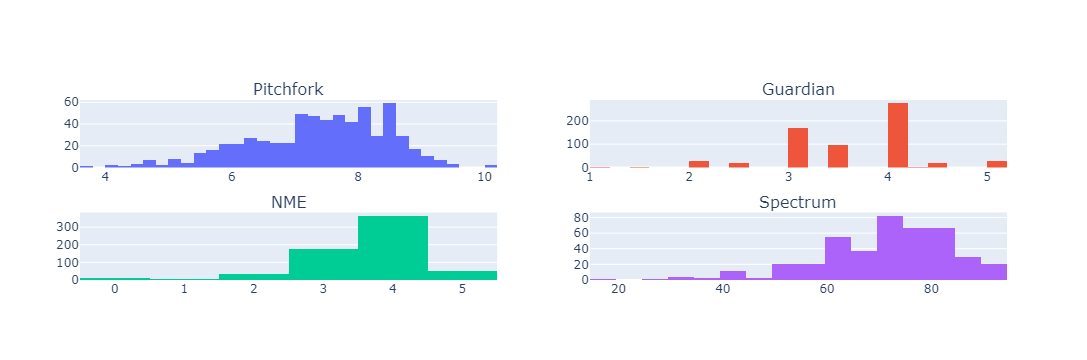

In [84]:
fig = make_subplots(rows=2, cols=2, subplot_titles=list(score_dfs.keys()))
i = 0

for platform, df in score_dfs.items():
    
    i += 1
    fig.add_trace(go.Histogram(x=df.loc[:, "Scores"]), row=(i - 1) // 2 + 1, col=(i + 1) % 2 + 1)
    
fig.update_layout(showlegend=False)

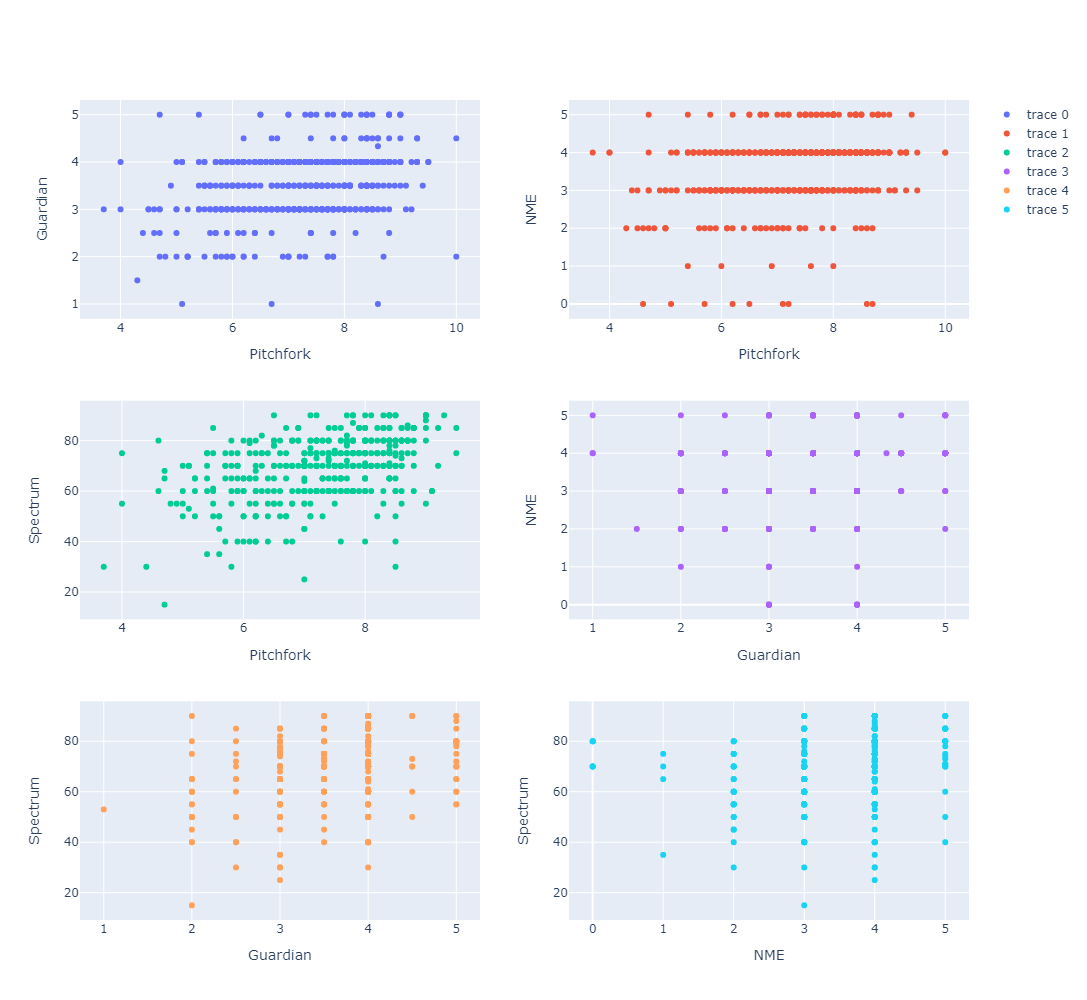

In [54]:
fig = make_subplots(rows=3, cols=2)

plot = 0

for i in range(4):
    for j in range(i + 1, 4):
        
        plot += 1
        
        k1, df1 = list(score_dfs.keys())[i], list(score_dfs.values())[i]
        k2, df2 = list(score_dfs.keys())[j], list(score_dfs.values())[j]
        df1 = df1.rename(columns={"Scores": "Scores1"})
        df2 = df2.rename(columns={"Scores": "Scores2"})
        
        joined_scores = pd.merge(df1, df2, on=["Artist", "Album"])
        
        row = (plot - 1) // 2 + 1
        col = (plot - 1) % 2 + 1
                
        fig.add_trace(go.Scatter(x=joined_scores.loc[:, "Scores1"], y=joined_scores.loc[:, "Scores2"], mode="markers"),
                      row=row, col=col)
        fig.update_xaxes(title_text=k1, row=row, col=col)
        fig.update_yaxes(title_text=k2, row=row, col=col)
        
    fig.update_layout(height=1000)
        
fig

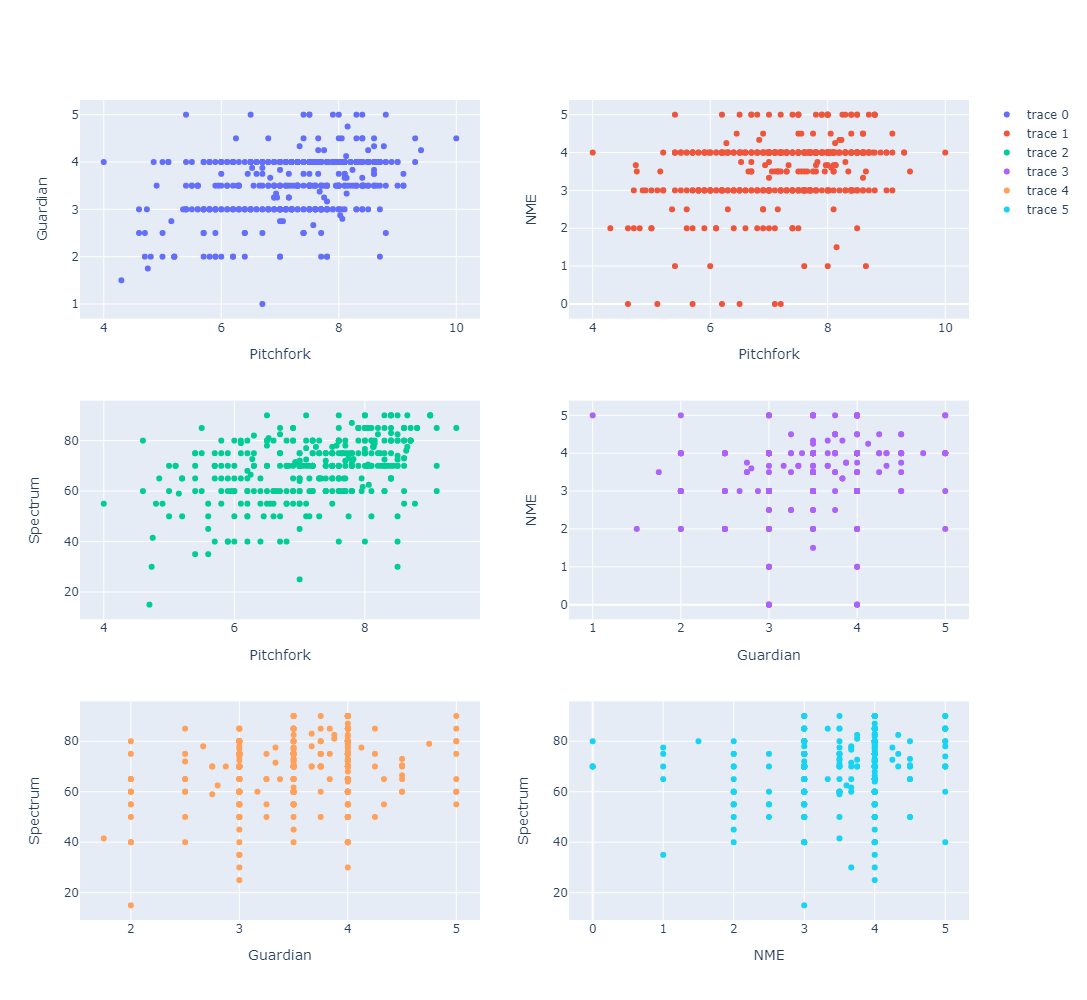

In [55]:
artist_ave = {platform: df.groupby("Artist")["Scores"].mean().reset_index() for platform, df in score_dfs.items()}

fig = make_subplots(rows=3, cols=2)

plot = 0

for i in range(4):
    for j in range(i + 1, 4):
        
        plot += 1
        
        k1, df1 = list(artist_ave.keys())[i], list(artist_ave.values())[i]
        k2, df2 = list(artist_ave.keys())[j], list(artist_ave.values())[j]
        df1 = df1.rename(columns={"Scores": "Scores1"})
        df2 = df2.rename(columns={"Scores": "Scores2"})
        
        joined_scores = pd.merge(df1, df2, on=["Artist"])
        
        row = (plot - 1) // 2 + 1
        col = (plot - 1) % 2 + 1
                
        fig.add_trace(go.Scatter(x=joined_scores.loc[:, "Scores1"], y=joined_scores.loc[:, "Scores2"], mode="markers"),
                      row=row, col=col)
        fig.update_xaxes(title_text=k1, row=row, col=col)
        fig.update_yaxes(title_text=k2, row=row, col=col)
        
    fig.update_layout(height=1000)
        
fig

In [56]:
std_scores = {}

all_scores = score_dfs["Pitchfork"].loc[:, [col not in ["Url", "Text", "Platform"] for col in score_dfs["Pitchfork"].columns]].rename({"Scores": "Pitchfork Scores"}, axis=1)

for platform in ["Guardian", "NME"]:
    
    next_platform = score_dfs[platform].loc[:, [col not in ["Url", "Text", "Platform", "Genres"] for col in score_dfs[platform].columns]].rename({"Scores": f"{platform} Scores"}, axis=1)
    all_scores = pd.merge(all_scores, next_platform,
                          on=["Artist", "Album"])

all_scores.loc[:, "Guardian Scores"] = all_scores.loc[:, "Guardian Scores"].multiply(2)
all_scores.loc[:, "NME Scores"] = all_scores.loc[:, "NME Scores"].astype(float).multiply(2)
all_scores = all_scores.sort_values(by="Album").reset_index(drop=True)

averages = all_scores.loc[:, ["Pitchfork Scores", "Guardian Scores", "NME Scores"]].mean(axis=1)

sp_filled = dfs_ave["Spectrum"].copy().sort_values(by="Album").reset_index(drop=True)
sp_no_data = sp_filled["Scores"] == -1
sp_filled.loc[~sp_no_data, "Scores"] = sp_filled.loc[~sp_no_data, "Scores"].div(10)
sp_filled.loc[sp_no_data, "Scores"] = averages.loc[sp_no_data]
sp_filled = sp_filled.rename({"Scores": "Spectrum Scores"}, axis=1).drop(["Platform", "Url"], axis=1)

all_scores = pd.merge(all_scores, sp_filled, on=["Artist", "Album"])

all_scores["Average Score"] = all_scores.loc[:, ["Pitchfork Scores", "Guardian Scores", "NME Scores", "Spectrum Scores"]].mean(axis=1)

all_scores.head()

Artist Album  Pitchfork Scores     Genres  Guardian Scores  \
0  taylor swift  1989               7.7  [Pop/R&B]              8.0   
1   mac demarco     2               8.2     [Rock]              6.0   
2         adele    25               7.3  [Pop/R&B]              6.0   
3          2:54  2:54               6.0  [Pop/R&B]              4.0   
4       beyonce     4               8.0  [Pop/R&B]              7.0   

   NME Scores                                               Text  \
0         6.0  1989 is Taylor Swift’s pop album. That is the ...   
1         8.0  On his early Makeout Videotape recordings, or ...   
2         6.0  \nNot quite a pop star, not exactly a diva, Ad...   
3         8.0  Few critics seriously enjoy giving negative re...   
4         4.0  \n\nBeyoncé \n4 \nRating: 3.2/5.0 \nLabel: Col...   

   Spectrum Scores  Average Score  
0         6.000000       6.925000  
1         7.000000       7.300000  
2         6.433333       6.433333  
3         4.000000       5.500000  
4         6.333333       6.333333

In [57]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def get_error(scoring, df):
    sp_error = scoring(df.loc[~sp_no_data, "Spectrum Scores"], df.loc[~sp_no_data, "Average Score"])
    errors = {platform: scoring(df.loc[:, f"{platform} Scores"], df.loc[:, "Average Score"]) for platform in platforms}
    errors["Spectrum"] = sp_error

    return pd.DataFrame(errors, index=["Platform"]).T

get_error(mean_squared_error, all_scores)

Platform
Pitchfork  0.662504
Guardian   1.027433
NME        1.504503
Spectrum   0.931269

In [58]:
get_error(mean_absolute_error, all_scores)

Platform
Pitchfork  0.629217
Guardian   0.768686
NME        0.888490
Spectrum   0.735774

In [59]:
sp_errors = all_scores.loc[~sp_no_data, :].apply(lambda x: (x["Spectrum Scores"] - x["Average Score"]) ** 2, axis=1)
errors = {platform: all_scores.apply(lambda x: (x[f"{platform} Scores"] - x["Average Score"]) ** 2, axis=1) for platform in platforms}
errors["Spectrum"] = sp_errors

errors_df = pd.DataFrame(errors)

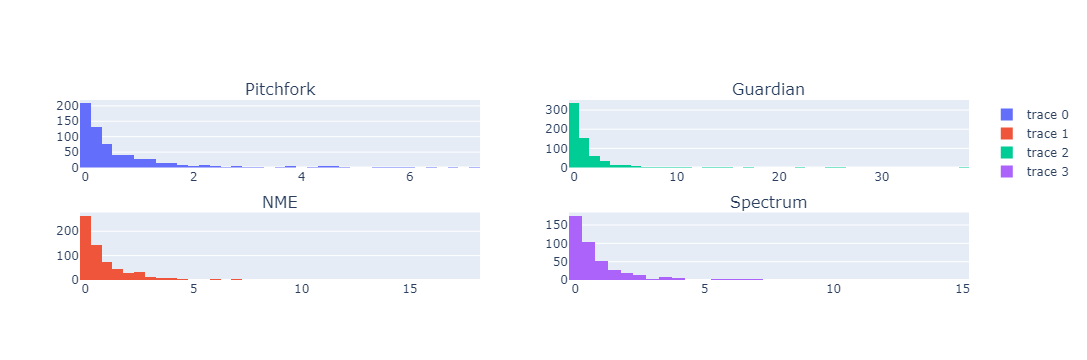

In [60]:
fig = make_subplots(rows=2, cols=2, subplot_titles=list(platforms))

i = 0

for platform in platforms:

    i += 1
    fig.add_trace(go.Histogram(x=errors_df.loc[:, platform]), row=(i - 1) % 2 + 1, col=(i - 1) // 2 + 1)
    
fig

In [61]:
errors_df = pd.merge(errors_df, all_scores, left_index=True, right_index=True)
errors_df

Pitchfork  Guardian       NME  Spectrum        Artist           Album  \
0     0.600625  1.155625  0.855625  0.855625  taylor swift            1989   
1     0.810000  1.690000  0.490000  0.090000   mac demarco               2   
2     0.751111  0.187778  0.187778       NaN         adele              25   
3     0.250000  2.250000  6.250000  2.250000          2:54            2:54   
4     2.777778  0.444444  5.444444       NaN       beyonce               4   
..         ...       ...       ...       ...           ...             ...   
636   1.562500  0.062500  0.062500  0.562500    kanye west          yeezus   
637   0.160000  1.690000  0.490000  0.040000  flying lotus    you're dead!   
638   2.102500  1.322500  0.722500  1.322500        iceage  you're nothing   
639   0.017778  3.737778  4.271111       NaN   marvin gaye  you're the man   
640   0.004444  0.001111  0.001111       NaN          yuck            yuck   

     Pitchfork Scores        Genres  Guardian Scores  NME Scores  \
0                 7.7     [Pop/R&B]              8.0         6.0   
1                 8.2        [Rock]              6.0         8.0   
2                 7.3     [Pop/R&B]              6.0         6.0   
3                 6.0     [Pop/R&B]              4.0         8.0   
4                 8.0     [Pop/R&B]              7.0         4.0   
..                ...           ...              ...         ...   
636               9.5         [Rap]              8.0         8.0   
637               8.3  [Electronic]             10.0         8.0   
638               8.6        [Rock]              6.0         8.0   
639               7.8     [Pop/R&B]              6.0        10.0   
640               8.1        [Rock]              8.0         8.0   

                                                  Text  Spectrum Scores  \
0    1989 is Taylor Swift’s pop album. That is the ...         6.000000   
1    On his early Makeout Videotape recordings, or ...         7.000000   
2    \nNot quite a pop star, not exactly a diva, Ad...         6.433333   
3    Few critics seriously enjoy giving negative re...         4.000000   
4    \n\nBeyoncé \n4 \nRating: 3.2/5.0 \nLabel: Col...         6.333333   
..                                                 ...              ...   
636  When Kanye West bombarded the “Saturday Night ...         7.500000   
637  There’s no point in saying that Steven Ellison...         8.500000   
638  The scene is littered with pop-punk bands tryi...         6.000000   
639  \nThe record being released as You’re the Man ...         7.933333   
640  \n\nYuck\nYuck\nRating: 2.9/5.0\nLabel: Fat Po...         8.033333   

     Average Score  
0         6.925000  
1         7.300000  
2         6.433333  
3         5.500000  
4         6.333333  
..             ...  
636       8.250000  
637       8.700000  
638       7.150000  
639       7.933333  
640       8.033333  

[641 rows x 13 columns]

In [62]:
errors_df.explode("Genres").loc[:, ["Pitchfork", "Spectrum", "Guardian", "NME", "Genres"]].groupby(["Genres"]).mean()

Pitchfork  Spectrum  Guardian       NME
Genres                                               
Electronic     0.755691  0.890037  1.179698  1.984380
Experimental   1.137704  1.238665  1.418795  1.267071
Folk/Country   0.422198  0.869602  0.494365  0.978531
Global         0.566028  0.307083  0.812028  0.555361
Jazz           1.708542  0.910208  2.751875  1.185208
Metal          0.941343  1.206458  1.747083  0.998935
NA             0.077917  1.284583  0.765139  0.920694
Pop/R&B        0.612924  0.787783  0.752280  1.485613
Rap            0.913845  0.860536  1.703094  1.272702
Rock           0.631998  0.978566  0.997298  1.482096

In [63]:
all_star_scores = all_scores.copy()

for platform in platforms:
    
    all_star_scores.loc[:, f"{platform} Scores"] = all_star_scores.loc[:, f"{platform} Scores"].div(2).apply(ceil)
    
all_star_scores.loc[:, "Average Score"] = all_star_scores.loc[:, ["Pitchfork Scores", "Guardian Scores", "NME Scores", "Spectrum Scores"]].mean(axis=1)

In [64]:
all_star_scores

Artist           Album  Pitchfork Scores        Genres  \
0    taylor swift            1989                 4     [Pop/R&B]   
1     mac demarco               2                 5        [Rock]   
2           adele              25                 4     [Pop/R&B]   
3            2:54            2:54                 3     [Pop/R&B]   
4         beyonce               4                 4     [Pop/R&B]   
..            ...             ...               ...           ...   
636    kanye west          yeezus                 5         [Rap]   
637  flying lotus    you're dead!                 5  [Electronic]   
638        iceage  you're nothing                 5        [Rock]   
639   marvin gaye  you're the man                 4     [Pop/R&B]   
640          yuck            yuck                 5        [Rock]   

     Guardian Scores  NME Scores  \
0                  4           3   
1                  3           4   
2                  3           3   
3                  2           4   
4                  4           2   
..               ...         ...   
636                4           4   
637                5           4   
638                3           4   
639                3           5   
640                4           4   

                                                  Text  Spectrum Scores  \
0    1989 is Taylor Swift’s pop album. That is the ...                3   
1    On his early Makeout Videotape recordings, or ...                4   
2    \nNot quite a pop star, not exactly a diva, Ad...                4   
3    Few critics seriously enjoy giving negative re...                2   
4    \n\nBeyoncé \n4 \nRating: 3.2/5.0 \nLabel: Col...                4   
..                                                 ...              ...   
636  When Kanye West bombarded the “Saturday Night ...                4   
637  There’s no point in saying that Steven Ellison...                5   
638  The scene is littered with pop-punk bands tryi...                3   
639  \nThe record being released as You’re the Man ...                4   
640  \n\nYuck\nYuck\nRating: 2.9/5.0\nLabel: Fat Po...                5   

     Average Score  
0             3.50  
1             4.00  
2             3.50  
3             2.75  
4             3.50  
..             ...  
636           4.25  
637           4.75  
638           3.75  
639           4.00  
640           4.50  

[641 rows x 9 columns]

In [65]:
get_error(mean_squared_error, all_star_scores)

Platform
Pitchfork  0.311525
Guardian   0.304505
NME        0.444910
Spectrum   0.286310

In [66]:
get_error(mean_absolute_error, all_star_scores)

Platform
Pitchfork  0.429407
Guardian   0.415367
NME        0.468409
Spectrum   0.407143

In [67]:
sp_star_errors = all_star_scores.loc[~sp_no_data, :].apply(lambda x: (x["Spectrum Scores"] - x["Average Score"]) ** 2, axis=1)
star_errors = {platform: all_star_scores.apply(lambda x: (x[f"{platform} Scores"] - x["Average Score"]) ** 2, axis=1) for platform in platforms}
star_errors["Spectrum"] = sp_star_errors

star_errors_df = pd.DataFrame(star_errors)

In [68]:
star_errors_df = pd.merge(star_errors_df, all_star_scores, left_index=True, right_index=True)

In [69]:
star_errors_df.explode("Genres").loc[:, ["Pitchfork", "Spectrum", "Guardian", "NME", "Genres"]].groupby(["Genres"]).mean().style.highlight_max(axis=1, color="pink")

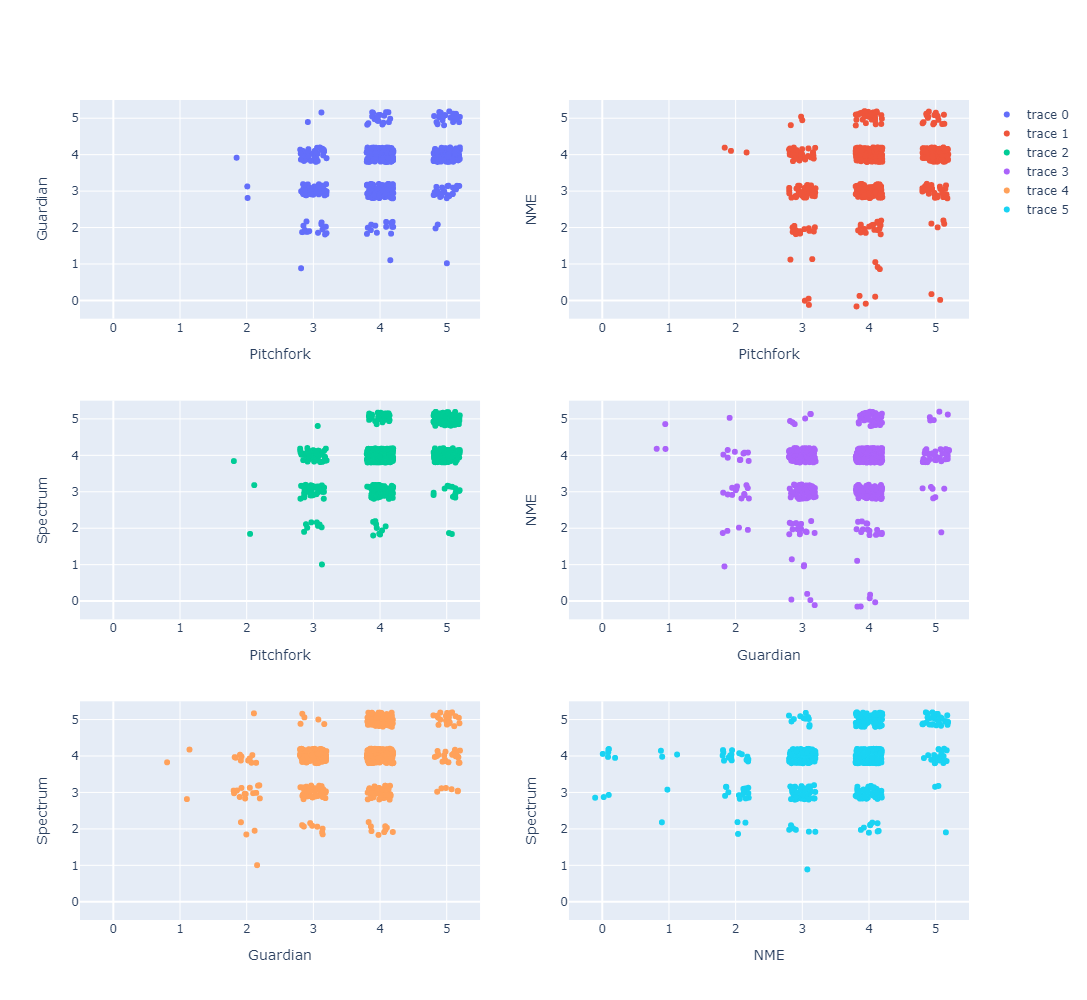

In [70]:
fig = make_subplots(rows=3, cols=2)
import random

def jitter(x, intensity):
    
    return x + np.random.uniform(low=-intensity, high=intensity)

plot = 0

for i in range(4):
    for j in range(i + 1, 4):
        
        plot += 1
        
        k1 = platforms[i]
        k2 = platforms[j]
        
        row = (plot - 1) // 2 + 1
        col = (plot - 1) % 2 + 1
                
        fig.add_trace(go.Scatter(x=all_star_scores.loc[:, f"{k1} Scores"].apply(jitter, intensity=0.2), 
                                 y=all_star_scores.loc[:, f"{k2} Scores"].apply(jitter, intensity=0.2), 
                                 mode="markers"),
                      row=row, col=col)
        fig.update_xaxes(title_text=k1, row=row, col=col, range=[-0.5, 5.5])
        fig.update_yaxes(title_text=k2, row=row, col=col, range=[-0.5, 5.5])
        
    fig.update_layout(height=1000)
        
fig

In [71]:
all_star_scores.loc[:, [f"{platform} Scores" for platform in platforms]].corr()

Pitchfork Scores  Guardian Scores  NME Scores  \
Pitchfork Scores          1.000000         0.314115    0.215333   
Guardian Scores           0.314115         1.000000    0.195838   
NME Scores                0.215333         0.195838    1.000000   
Spectrum Scores           0.420036         0.338157    0.319757   

                  Spectrum Scores  
Pitchfork Scores         0.420036  
Guardian Scores          0.338157  
NME Scores               0.319757  
Spectrum Scores          1.000000

In [72]:
all_scores.head(30).loc[7:20, all_scores.columns != "Text"]

Artist                                      Album  \
7             wutang clan                          a better tomorrow   
8                the 1975  a brief inquiry into online relationships   
9               sheer mag                             a distant call   
10  everything everything                              a fever dream   
11          the districts                     a flourish and a spoil   
12           fontaines dc                             a hero's death   
13                 m ward                      a wasteland companion   
14             the weeknd                                after hours   
15           broken bells                            after the disco   
16            merchandise                              after the end   
17             goodie mob                    age against the machine   
18            angel olsen                                all mirrors   
19         arctic monkeys                                         am   
20             dan deacon                                    america   

    Pitchfork Scores              Genres  Guardian Scores  NME Scores  \
7                5.9               [Rap]              6.0         6.0   
8                8.5              [Rock]              8.0        10.0   
9                7.8              [Rock]              8.0         8.0   
10               7.1              [Rock]              8.0         8.0   
11               5.6              [Rock]              6.0         8.0   
12               8.1              [Rock]             10.0         8.0   
13               6.3              [Rock]              7.0         6.0   
14               7.9           [Pop/R&B]              8.0         8.0   
15               5.4  [Electronic, Rock]              6.0         8.0   
16               7.0              [Rock]              6.0         8.0   
17               6.8      [Pop/R&B, Rap]              6.0         8.0   
18               8.9              [Rock]              7.0        10.0   
19               8.0              [Rock]              8.0        10.0   
20               7.1        [Electronic]              8.0         8.0   

    Spectrum Scores  Average Score  
7          6.000000       5.975000  
8          8.833333       8.833333  
9          7.933333       7.933333  
10         7.700000       7.700000  
11         3.500000       5.775000  
12         7.000000       8.275000  
13         7.500000       6.700000  
14         7.966667       7.966667  
15         6.500000       6.475000  
16         2.500000       5.875000  
17         5.500000       6.575000  
18         8.633333       8.633333  
19         8.000000       8.500000  
20         8.000000       7.775000

In [73]:
all_star_scores.loc[all_star_scores["NME Scores"] == 0, "NME Scores"] = 1

In [74]:
# Guardian and Pitchfork

# Calculation of T index John Fleenor et Al

from scipy import stats

n = 5
k = 2

P = ((n - 1) * sum([2 ** (x - 1) for x in range(1, k)]) + n) / n ** k

N1 = sum(all_star_scores["Guardian Scores"] == all_star_scores["Pitchfork Scores"])
N = all_star_scores.shape[0]

T = (N1 - N * P) / (N - N * P)

N2 = N - N1

chi_2 = ((N1 - N * P - 0.5) ** 2) / (N * P) + ((N2 - N * (1 - P) - 0.5) ** 2) / (N * (1 - P))
p_value = 1 - stats.chi2.cdf(chi_2, 1)

p_value

8.511906438357641e-06

In [75]:
import pingouin as pg

# ICC calculations

melted_df = pd.melt(all_star_scores.loc[:, ["Artist", "Album", "Pitchfork Scores", "Guardian Scores", "NME Scores"]], id_vars=["Artist", "Album"])
melted_df["Album"] = melted_df["Album"] + ", " + melted_df["Artist"]

melted_df

pg.intraclass_corr(data=melted_df, targets="Album", raters="variable", ratings="value")

Type              Description       ICC         F  df1   df2  \
0   ICC1   Single raters absolute  0.176892  1.644722  640  1282   
1   ICC2     Single random raters  0.210821  1.950337  640  1280   
2   ICC3      Single fixed raters  0.240571  1.950337  640  1280   
3  ICC1k  Average raters absolute  0.391994  1.644722  640  1282   
4  ICC2k    Average random raters  0.444883  1.950337  640  1280   
5  ICC3k     Average fixed raters  0.487268  1.950337  640  1280   

           pval         CI95%  
0  4.830450e-14  [0.13, 0.23]  
1  4.745680e-24  [0.14, 0.28]  
2  4.745680e-24  [0.19, 0.29]  
3  4.830450e-14  [0.31, 0.47]  
4  4.745680e-24  [0.33, 0.54]  
5  4.745680e-24  [0.41, 0.55]

This suggests that the scoring systems used by different platforms are not reliable as scoring systems.